# Fitting Gaussian Process Dataset

## Import libraries


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from create_data import gaussian_process, create_kernel, create_mean_func
from DKL import DKLModel, SimpleNN
from GP import optimize_hyperparameters, fit_gaussian_process
from NN import NN
import torch
import torch.nn as nn
import gpytorch

## Create a dataset

In [9]:
### Simulate Data
np.random.seed(42)
torch.manual_seed(42)

# Parameters
N = 400
x_min, x_max = 0, 10

#  Uniform Grid
X = np.linspace(x_min, x_max, N)

# Kernel and mean functions
length_scale = 1.0
sigma_f = 1.0
sigma_n = 0.1
kernel_func = create_kernel(length_scale, sigma_f)
mean_func = create_mean_func(0.0)

# Simulate GP
Y = gaussian_process(X, mean_func, kernel_func, sigma_n)

### Split Data
X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.5)

In [10]:
# Prepare Tensors
X_train_torch = torch.tensor(X_train).float().unsqueeze(-1)
Y_train_torch = torch.tensor(Y_train).float().unsqueeze(-1)
X_torch = torch.tensor(X).float().unsqueeze(-1)

# Sort X for Plotting
idx = np.argsort(X)
X_sorted = X[idx]

# Neural Network

In [11]:
# Train NN
NN_model = NN()
NN_model.fit(X_train_torch, Y_train_torch)

# Predict
Y_pred_NN = NN_model.predict(X_torch).detach()

# Convert to NumPy for Plotting
Y_pred_NN = Y_pred_NN.numpy().squeeze()

# Sort Y_pred_NN for Plotting
Y_pred_NN = Y_pred_NN[idx]

Epoch 1/1000: Train Loss = 10.5590
Epoch 2/1000: Train Loss = 2.3112
Epoch 3/1000: Train Loss = 0.8305
Epoch 4/1000: Train Loss = 2.9730
Epoch 5/1000: Train Loss = 4.3565
Epoch 6/1000: Train Loss = 3.7995
Epoch 7/1000: Train Loss = 2.3208
Epoch 8/1000: Train Loss = 1.0539
Epoch 9/1000: Train Loss = 0.6051
Epoch 10/1000: Train Loss = 0.9519
Epoch 11/1000: Train Loss = 1.6073
Epoch 12/1000: Train Loss = 2.0210
Epoch 13/1000: Train Loss = 1.9439
Epoch 14/1000: Train Loss = 1.4848
Epoch 15/1000: Train Loss = 0.9361
Epoch 16/1000: Train Loss = 0.5713
Epoch 17/1000: Train Loss = 0.5133
Epoch 18/1000: Train Loss = 0.7003
Epoch 19/1000: Train Loss = 0.9499
Epoch 20/1000: Train Loss = 1.0823
Epoch 21/1000: Train Loss = 1.0207
Epoch 22/1000: Train Loss = 0.8129
Epoch 23/1000: Train Loss = 0.5787
Epoch 24/1000: Train Loss = 0.4316
Epoch 25/1000: Train Loss = 0.4198
Epoch 26/1000: Train Loss = 0.5120
Epoch 27/1000: Train Loss = 0.6259
Epoch 28/1000: Train Loss = 0.6717
Epoch 29/1000: Train Loss = 

# Gaussian Process

In [12]:
# Optimize Hyperparameters
length_scale_opt, sigma_f_opt, sigma_n_opt = optimize_hyperparameters(X_train, Y_train)
kernel_func_gp = create_kernel(length_scale_opt, sigma_f_opt)
print(f"Optimized length_scale: {length_scale_opt:.3f}, sigma_f: {sigma_f_opt:.3f}, sigma_n: {sigma_n_opt:.3f}")

mean_post, cov_post = fit_gaussian_process(X_train, Y_train, X, kernel_func_gp, sigma_n_opt)

# Sort for Plotting
mean_post_sorted = mean_post[idx]
cov_post_sorted = cov_post[np.ix_(idx, idx)]


Optimized length_scale: 0.974, sigma_f: 0.785, sigma_n: 0.098


# Deep Kernel Learning

In [13]:
# Initialize NN
feature_extractor = SimpleNN()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

Y_train_torch = Y_train_torch.reshape(-1)

model = DKLModel(X_train_torch, Y_train_torch, likelihood, feature_extractor)

# Train DKL
model.fit(X_train_torch, Y_train_torch)

# Predict
model.eval()
likelihood.eval()

with torch.no_grad():
    Y_pred_dkl = likelihood(model(X_torch))

# Get Predictions
mean = Y_pred_dkl.mean.detach().numpy()
lower, upper = Y_pred_dkl.confidence_region()
lower = lower.detach().numpy()
upper = upper.detach().numpy()

# Sort
mean = mean[idx]
lower = lower[idx]
upper = upper[idx]

Epoch 1/100: Train Loss = 1.0658
Epoch 2/100: Train Loss = 0.8849
Epoch 3/100: Train Loss = 0.8261
Epoch 4/100: Train Loss = 0.8227
Epoch 5/100: Train Loss = 0.8259
Epoch 6/100: Train Loss = 0.8281
Epoch 7/100: Train Loss = 0.8287
Epoch 8/100: Train Loss = 0.8280
Epoch 9/100: Train Loss = 0.8261
Epoch 10/100: Train Loss = 0.8233
Epoch 11/100: Train Loss = 0.8196
Epoch 12/100: Train Loss = 0.8153
Epoch 13/100: Train Loss = 0.8103
Epoch 14/100: Train Loss = 0.8049
Epoch 15/100: Train Loss = 0.7990
Epoch 16/100: Train Loss = 0.7928
Epoch 17/100: Train Loss = 0.7863
Epoch 18/100: Train Loss = 0.7796
Epoch 19/100: Train Loss = 0.7729
Epoch 20/100: Train Loss = 0.7662
Epoch 21/100: Train Loss = 0.7600
Epoch 22/100: Train Loss = 0.7547
Epoch 23/100: Train Loss = 0.7510
Epoch 24/100: Train Loss = 0.7490
Epoch 25/100: Train Loss = 0.7478
Epoch 26/100: Train Loss = 0.7451
Epoch 27/100: Train Loss = 0.7402
Epoch 28/100: Train Loss = 0.7345
Epoch 29/100: Train Loss = 0.7292
Epoch 30/100: Train Los

# Plotting

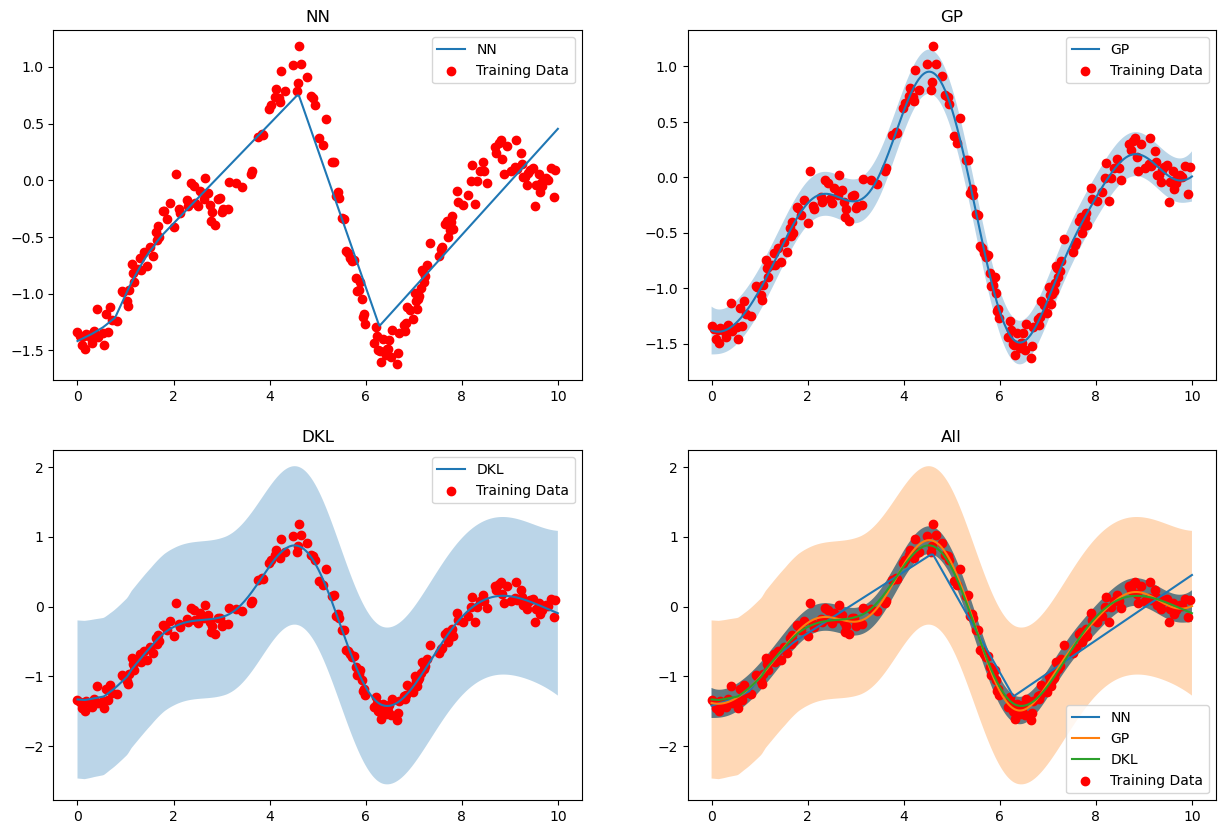

In [14]:
ax, fig = plt.subplots(2, 2, figsize=(15, 10))

# NN
fig[0, 0].plot(X_sorted, Y_pred_NN, label="NN")
fig[0, 0].scatter(X_train, Y_train, color='red', label="Training Data")
fig[0, 0].set_title("NN")
fig[0, 0].legend()

# GP
fig[0, 1].plot(X_sorted, mean_post_sorted, label="GP")
fig[0, 1].fill_between(X_sorted, mean_post_sorted - 1.96 * np.sqrt(np.diag(cov_post_sorted)),
                       mean_post_sorted + 1.96 * np.sqrt(np.diag(cov_post_sorted)), alpha=0.3)
fig[0, 1].scatter(X_train, Y_train, color='red', label="Training Data")
fig[0, 1].set_title("GP")
fig[0, 1].legend()

# DKL
fig[1, 0].plot(X_sorted, mean, label="DKL")
fig[1, 0].fill_between(X_sorted, lower, upper, alpha=0.3)
fig[1, 0].scatter(X_train, Y_train, color='red', label="Training Data")
fig[1, 0].set_title("DKL")
fig[1, 0].legend()

# All
fig[1, 1].plot(X_sorted, Y_pred_NN, label="NN")
fig[1, 1].plot(X_sorted, mean_post_sorted, label="GP")
fig[1, 1].fill_between(X_sorted, mean_post_sorted - 1.96 * np.sqrt(np.diag(cov_post_sorted)),
                       mean_post_sorted + 1.96 * np.sqrt(np.diag(cov_post_sorted)), alpha=1.0)
fig[1, 1].plot(X_sorted, mean, label="DKL")
fig[1, 1].fill_between(X_sorted, lower, upper, alpha=0.3)
fig[1, 1].scatter(X_train, Y_train, color='red', label="Training Data")
fig[1, 1].set_title("All")
fig[1, 1].legend()